Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.73MB/s]


Epoch: 1/10 | Batch: 0/938 | Loss: 2.3012
Epoch: 1/10 | Batch: 100/938 | Loss: 0.9022
Epoch: 1/10 | Batch: 200/938 | Loss: 0.6092
Epoch: 1/10 | Batch: 300/938 | Loss: 0.6411
Epoch: 1/10 | Batch: 400/938 | Loss: 0.6923
Epoch: 1/10 | Batch: 500/938 | Loss: 0.5599
Epoch: 1/10 | Batch: 600/938 | Loss: 0.3658
Epoch: 1/10 | Batch: 700/938 | Loss: 0.3502
Epoch: 1/10 | Batch: 800/938 | Loss: 0.4661
Epoch: 1/10 | Batch: 900/938 | Loss: 0.3774
Epoch 1/10 | Train Loss: 0.5450 | Train Acc: 79.94% | Test Loss: 0.3538 | Test Acc: 86.97%
Epoch: 2/10 | Batch: 0/938 | Loss: 0.4938
Epoch: 2/10 | Batch: 100/938 | Loss: 0.5488
Epoch: 2/10 | Batch: 200/938 | Loss: 0.2236
Epoch: 2/10 | Batch: 300/938 | Loss: 0.4518
Epoch: 2/10 | Batch: 400/938 | Loss: 0.3540
Epoch: 2/10 | Batch: 500/938 | Loss: 0.4612
Epoch: 2/10 | Batch: 600/938 | Loss: 0.3151
Epoch: 2/10 | Batch: 700/938 | Loss: 0.4653
Epoch: 2/10 | Batch: 800/938 | Loss: 0.3575
Epoch: 2/10 | Batch: 900/938 | Loss: 0.4345
Epoch 2/10 | Train Loss: 0.3510 |

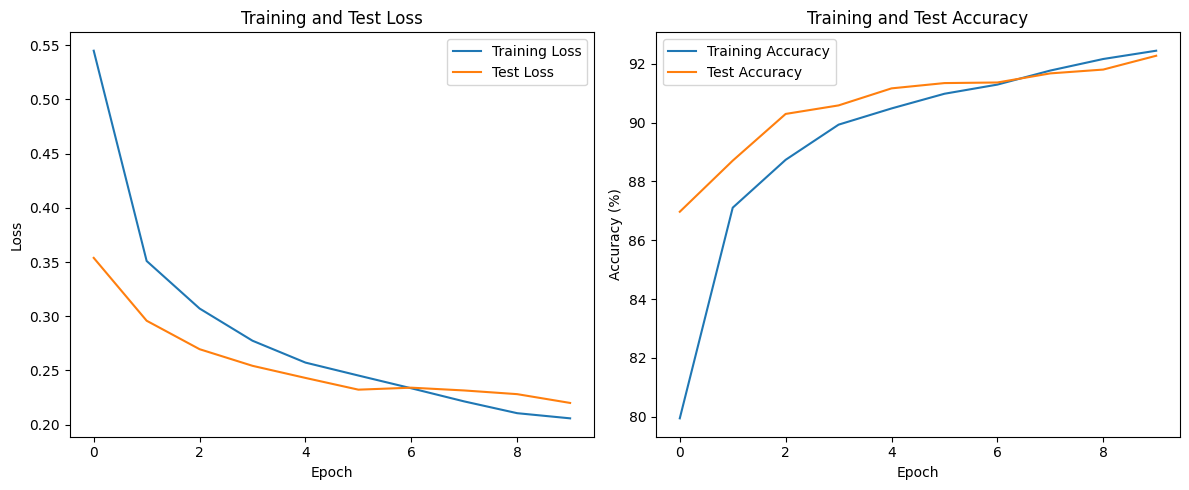

Model saved as fashion_mnist_model.pth


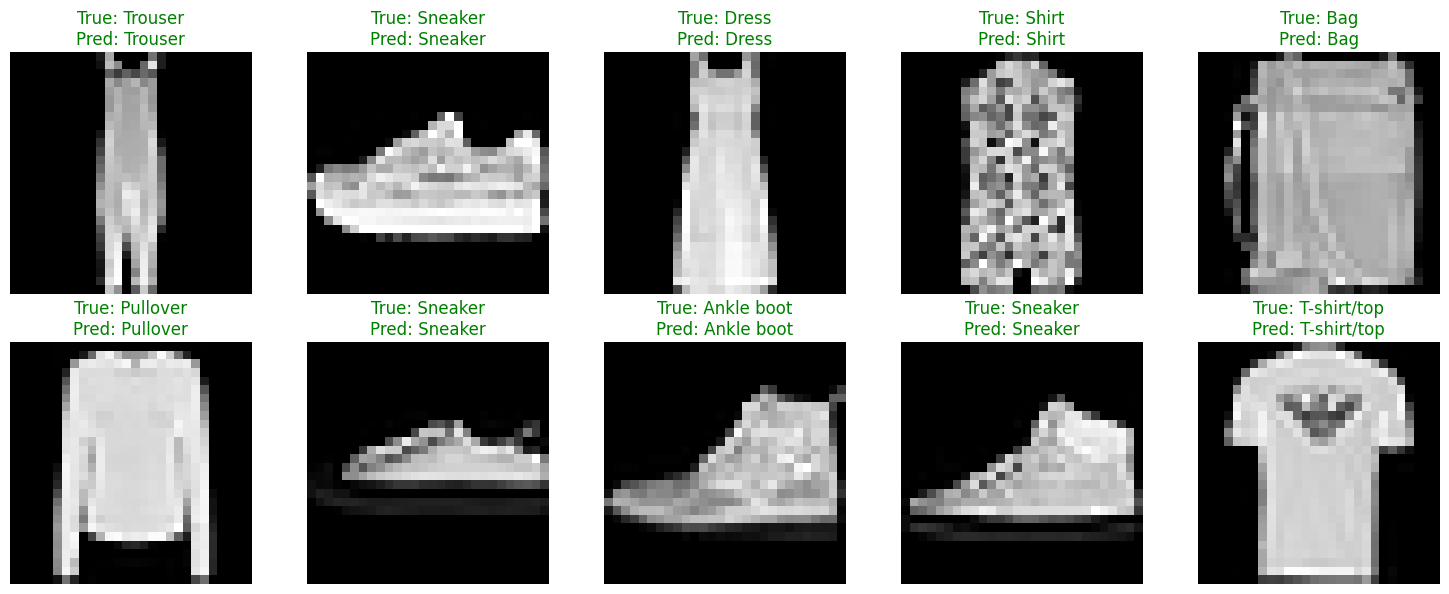

Final Test Accuracy: 92.28%


In [5]:
# Install required libraries
!pip install torch torchvision matplotlib

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple CNN model for Fashion-MNIST
class FashionMNISTModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionMNISTModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 3 * 3, 512),  # Adjusted for 28x28 input -> 3x3 after conv layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
model = FashionMNISTModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs} | '
                  f'Batch: {batch_idx}/{len(train_loader)} | '
                  f'Loss: {loss.item():.4f}')

    # Calculate training accuracy and loss for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # Calculate test accuracy and loss for this epoch
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | '
          f'Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%')

training_time = time.time() - start_time
print(f'Training completed in {training_time:.2f} seconds')

# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the model
torch.save(model.state_dict(), 'fashion_mnist_model.pth')
print('Model saved as fashion_mnist_model.pth')

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Inference function
def predict_image(image, model):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = output.max(1)
        return predicted.item()

# Test the model on a few images from the test set
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Get a random test image
    idx = np.random.randint(0, len(test_dataset))
    image, label = test_dataset[idx]

    # Make prediction
    prediction = predict_image(image.unsqueeze(0), model)

    # Plot the image
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'True: {class_names[label]}\nPred: {class_names[prediction]}')
    axes[i].axis('off')

    # Color the title based on whether prediction is correct
    if label == prediction:
        axes[i].title.set_color('green')
    else:
        axes[i].title.set_color('red')

plt.tight_layout()
plt.savefig('predictions.png')
plt.show()

# Calculate final test accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

final_accuracy = 100. * correct / total
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

In [12]:
# Load the saved model
model = FashionMNISTModel()
model.load_state_dict(torch.load('fashion_mnist_model.pth'))
model.to(device)
model.eval()

# Preprocess your image (should be 28x28 grayscale)
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Make prediction
def predict_image(image, model):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = output.max(1)
        return predicted.item()


Saving tr.JPG to tr.JPG
Inverted automatically: True
Prediction: Trouser


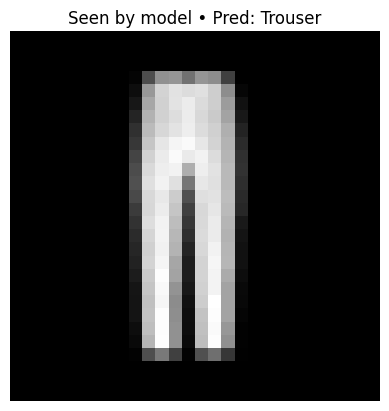

Trouser      : 92.7%
Dress        : 6.2%
Shirt        : 0.5%


In [20]:
from google.colab import files
from PIL import Image, ImageOps, ImageStat
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Same normalization as training
NORM = T.Normalize((0.5,), (0.5,))

def _estimate_bg_brightness(img_gray_0to1):
    # look at 4 corners to guess background brightness (mean of 16x16 patches)
    w, h = img_gray_0to1.size
    patch = 8
    coords = [(0,0),(w-patch,0),(0,h-patch),(w-patch,h-patch)]
    vals = []
    for x,y in coords:
        crop = img_gray_0to1.crop((x,y,x+patch,y+patch))
        vals.append(np.array(crop, dtype=np.float32).mean())
    return float(np.mean(vals))

def _to_mnist_canvas(img_gray, target=28, max_object=22):
    """
    Preserve aspect ratio, autocontrast, paste centered on 28x28 black canvas.
    max_object: max side for the object area so we keep some margins like Fashion-MNIST.
    """
    # Autocontrast to boost foreground vs background
    img = ImageOps.autocontrast(img_gray)

    # Resize with aspect ratio so the longer side == max_object
    w, h = img.size
    if w >= h:
        new_w = max_object
        new_h = int(h * (max_object / w))
    else:
        new_h = max_object
        new_w = int(w * (max_object / h))
    img = img.resize((max(1,new_w), max(1,new_h)), Image.BILINEAR)

    # Paste centered on 28x28 black canvas (background ~ 0 like Fashion-MNIST)
    canvas = Image.new("L", (target, target), color=0)
    x = (target - img.size[0]) // 2
    y = (target - img.size[1]) // 2
    canvas.paste(img, (x, y))
    return canvas

def preprocess_photo_like_fashion_mnist(path, try_auto_invert=True):
    # Open, convert to grayscale in [0..255]
    pil = Image.open(path).convert("L")

    # Optional heuristic: if background looks bright (white sheet), invert
    if try_auto_invert:
        # estimate on 0..1 image for convenience
        bg_level = _estimate_bg_brightness(pil.point(lambda p: p/255.0))
        invert_needed = bg_level > 0.6   # tweak threshold if needed
    else:
        invert_needed = False

    if invert_needed:
        pil = ImageOps.invert(pil)

    # Fit to 28x28 canvas with margins similar to Fashion-MNIST
    canvas = _to_mnist_canvas(pil, target=28, max_object=22)

    # To tensor + normalize exactly like training
    x = TF.to_tensor(canvas)            # -> [1,28,28] in [0,1]
    x = NORM(x)                         # same normalization as training
    x = x.unsqueeze(0).to(device)       # -> [1,1,28,28]
    return x, canvas, invert_needed

def predict_with_probs(x, model):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred = int(probs.argmax())
    return pred, probs

# ===== Upload & run =====
uploaded = files.upload()
file_path = next(iter(uploaded))

x, viz_img, inverted = preprocess_photo_like_fashion_mnist(file_path, try_auto_invert=True)
pred_idx, probs = predict_with_probs(x, model)

print(f"Inverted automatically: {inverted}")
print(f"Prediction: {class_names[pred_idx]}")

# Show the 28x28 the model actually saw
plt.imshow(viz_img, cmap="gray")
plt.title(f"Seen by model • Pred: {class_names[pred_idx]}")
plt.axis("off")
plt.show()

# Show top-3 classes with probabilities
topk = 3
top_idx = probs.argsort()[-topk:][::-1]
for i in top_idx:
    print(f"{class_names[i]:<12} : {probs[i]*100:.1f}%")


Saving sne.JPG to sne (1).JPG
Inverted automatically: True
Prediction: Sneaker


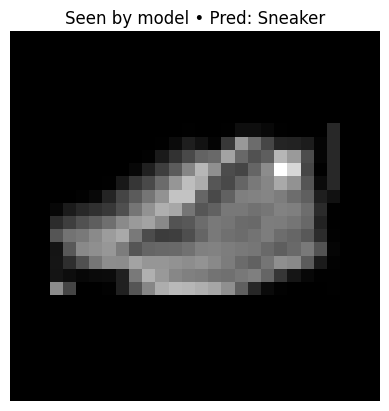

Sneaker      : 98.3%
Ankle boot   : 0.7%
Bag          : 0.3%


In [21]:
# ===== Upload & run =====
uploaded = files.upload()
file_path = next(iter(uploaded))

x, viz_img, inverted = preprocess_photo_like_fashion_mnist(file_path, try_auto_invert=True)
pred_idx, probs = predict_with_probs(x, model)

print(f"Inverted automatically: {inverted}")
print(f"Prediction: {class_names[pred_idx]}")

# Show the 28x28 the model actually saw
plt.imshow(viz_img, cmap="gray")
plt.title(f"Seen by model • Pred: {class_names[pred_idx]}")
plt.axis("off")
plt.show()

# Show top-3 classes with probabilities
topk = 3
top_idx = probs.argsort()[-topk:][::-1]
for i in top_idx:
    print(f"{class_names[i]:<12} : {probs[i]*100:.1f}%")